In [26]:
from typing import List
from pathlib import Path

import numpy as np
from mypy_extensions import TypedDict
from superjson import json

from data import Flickr30k
from utils import show_image

split = "test"
loader = Flickr30k(split=split)
output_folder = Path(f"./{split}-translations")

In [29]:
class Translation(TypedDict):
    markers: List[str]
    original_sentence: str
    translated_sentences: List[str]


def save_annotation(
    image_id: int,
    caption_id: int,
    original_sentence: str,
    translated_sentence: str,
    marker: str,
    folder: Path = output_folder,
):
    obj = Translation(
        markers=[marker],
        original_sentence=original_sentence,
        translated_sentences=[translated_sentence],
    )
    translation_file: Path = folder / str(image_id) / f"{caption_id}.json"
    if translation_file.is_file():
        data = Translation(**json.load(str(translation_file), verbose=False))
        data["markers"].append(marker)
        data["translated_sentences"].append(translated_sentence)
        obj = data
    translation_file.parent.mkdir(parents=True, exist_ok=True)
    json.dump(obj, str(translation_file), indent=2, overwrite=True, verbose=False)
    print(f"Saved IMG_{image_id}-CAP_{caption_id}.")
    

def load_annotation(
    image_id: int,
    caption_id: int,
    folder: Path = output_folder,
) -> Translation:
    translation_file: Path = folder / str(image_id) / f"{caption_id}.json"
    if translation_file.is_file():
        data = Translation(**json.load(str(translation_file), verbose=False))
        return data["translated_sentences"]
    msg = f"No translation file found for ID IMG_{image_id}-CAP_{caption_id}."
    raise ValueError(msg)

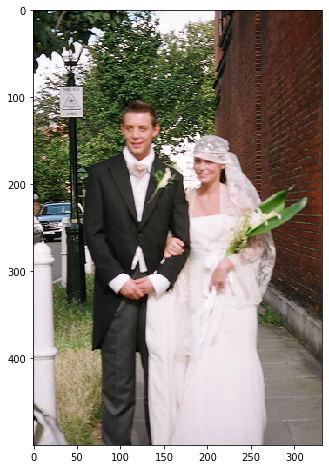

Image #0, caption #0:
 bride and groom walking side by side out of focus on pathway next to brick building .
Translation: >skip
Saved IMG_0-CAP_0.
Image #0, caption #1:
 A beautiful bride walking on a sidewalk with her new husband .
Translation: :skip
Saved IMG_0-CAP_1.
Image #0, caption #2:
 A recently married couple pose for the camera .
Translation: >skip
Saved IMG_0-CAP_2.
Image #0, caption #3:
 A groom and bride are standing arm in arm .
Translation: >skip
Saved IMG_0-CAP_3.
Image #0, caption #4:
 A couple getting married .
Translation: >skip
Saved IMG_0-CAP_4.


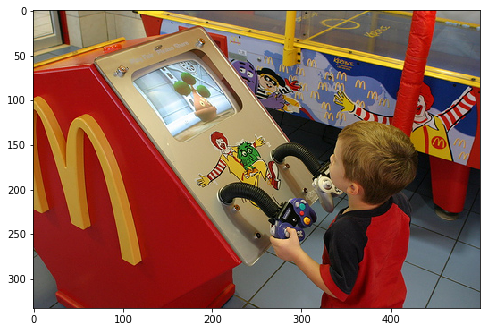

Image #1, caption #0:
 A little boy plays with a Nintendo GameCube controller inside a McDonald 's .


In [ ]:
def edit_translation(dataset: Flickr30k, image_index: int, caption_index: int):
    image, captions = dataset[image_index]
    try:
        translations = load_annotation(image_index, caption_index)
    except ValueError as e:
        print(str(e))
        return
    show_image(np.asarray(image))
    print("***Editing mode*** (type 'q' to quit)")
    print(f"Image #{image_index}, caption #{caption_index}:")
    print(captions[caption_index])
    print("Translations:")
    print(*translations, sep="\n")
    user_input = input("Translation: ")
    if user_input != "q":
        save_annotation(image_index, caption_index, captions[caption_index], user_input, "edit")
    print("Exiting editing mode.")
    return
    
mode = "normal"
for i, (image, captions) in enumerate(loader):
    show_image(np.asarray(image))
    for j, caption in enumerate(captions):
        result = None
        while result is None:
            print(f"Image #{i}, caption #{j}:")
            print(caption)
            user_input = input("Translation: ")
            if not user_input:
                print("Empty string is not allowed.")
                continue
            result = (user_input, mode)
            if user_input[0] == ">":
                command = user_input[1:]
                if command == "skip":
                    result = ("", "skip")
                elif command == "undo":
                    print("Edit previous translation.")
                    previous_caption = (i, j - 1) if j != 0 else (i - 1, 4) 
                    edit_translation(loader, *previous_caption)
                    show_image(np.asarray(image))
                    result = None
                    continue
            if "|" in user_input:
                result = (user_input, "check")
            save_annotation(i, j, caption, *result)

